# Super resolution
This notebook tries to repeat the result of [this article](https://arxiv.org/pdf/1511.04587.pdf "Accurate Image Super-Resolution Using Very Deep Convolutional Networks")

## Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib 
import caffe
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
delta = abs(-9-1-5+3)

In [3]:
def crop_center(imobj, new_width, new_height):
    width, height =imobj.size
    left = (width - N)/2
    top = (height - N)/2
    right = (width + N)/2
    bottom = (height + N)/2

    return imobj.crop((left, top, right, bottom))

def generate_crops(number, width, height, crop_width, crop_height):
    crops = []
    for i in range(number):
        x = randint(0,width-crop_width)
        y = randint(0,height-crop_height)
        crops.append((x, y, x + crop_width, y + crop_height))
    return crops

### Prepare dataset

### Train

In [25]:
import os
N = 297
SUB = 33
Nsubs = 30
ScaleFactor = 2
folder = 'datasets/berkley/BSDS300/images/train/original/'
originals = [os.path.join(folder,f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder,f))]
hrdir = os.path.join(folder,'hr/')
if not os.path.exists(hrdir):
    os.makedirs(hrdir)
    
lrdir = os.path.join(folder,'lr/')
if not os.path.exists(lrdir):
    os.makedirs(lrdir)

In [26]:
from PIL import Image
from PIL import ImageFilter
from random import randint


for idx, im in enumerate(originals):
    pim = Image.open(im)
    pim = crop_center(pim, N, N)
    crops = generate_crops(Nsubs, N, N, SUB, SUB)
    for j, crop_tuple in enumerate(crops):
        sim = pim.crop(crop_tuple)
        sim.save(os.path.join(hrdir,'%d-%d.jpg' % (idx,j)))
        sim = sim.filter(ImageFilter.GaussianBlur(radius=1))
        sim = sim.resize((SUB // ScaleFactor, SUB // ScaleFactor), Image.BICUBIC)
        sim = sim.resize((SUB+delta,SUB+delta), Image.BICUBIC)
        sim.save(os.path.join(lrdir,'%d-%d-F%d.jpg' % (idx,j,ScaleFactor)))
        
    
    

In [27]:
import lmdb

lrs = sorted([os.path.join(lrdir,f) for f in os.listdir(lrdir) if os.path.isfile(os.path.join(lrdir,f))])
in_db = lmdb.open('berkley-train-image-lmdb-srcnn-dataset-x', map_size=int(1e12))
with in_db.begin(write=True) as in_txn:
    for in_idx, in_ in enumerate(lrs):
        im = Image.open(in_) # load image:
        im = np.array(im) # - as np.uint8 {0, ..., 255}
        im = im[:,:,::-1] # - in BGR (switch from RGB)
        im = im.transpose((2,0,1)) # - in Channel x Height x Width order (switch from H x W x C)
        im_dat = caffe.io.array_to_datum(im)
        in_txn.put('{:0>10d}'.format(in_idx), im_dat.SerializeToString())
in_db.close()

hrs = sorted([os.path.join(hrdir,f) for f in os.listdir(hrdir) if os.path.isfile(os.path.join(hrdir,f))])
orim_db = lmdb.open('berkley-train-orim-image-lmdb-srcnn-dataset-x', map_size=int(1e12))
with orim_db.begin(write=True) as in_txn:
    for in_idx, in_ in enumerate(hrs):
        orim = np.array(Image.open(in_))
        orim = orim[:,:,::-1]
        orim = orim.transpose((2,0,1))
        
        im_res = caffe.io.array_to_datum(orim)
        in_txn.put('{:0>10d}'.format(in_idx), im_res.SerializeToString())
orim_db.close()

In [28]:
print(lrs[:5])
print(hrs[:5])

['datasets/berkley/BSDS300/images/train/original/lr/0-0-F2.jpg', 'datasets/berkley/BSDS300/images/train/original/lr/0-1-F2.jpg', 'datasets/berkley/BSDS300/images/train/original/lr/0-10-F2.jpg', 'datasets/berkley/BSDS300/images/train/original/lr/0-11-F2.jpg', 'datasets/berkley/BSDS300/images/train/original/lr/0-12-F2.jpg']
['datasets/berkley/BSDS300/images/train/original/hr/0-0.jpg', 'datasets/berkley/BSDS300/images/train/original/hr/0-1.jpg', 'datasets/berkley/BSDS300/images/train/original/hr/0-10.jpg', 'datasets/berkley/BSDS300/images/train/original/hr/0-11.jpg', 'datasets/berkley/BSDS300/images/train/original/hr/0-12.jpg']


### Test (actually validation)

In [29]:
import os
N = 297
SUB = 33
Nsubs = 30
ScaleFactor = 2
folder = 'datasets/berkley/BSDS300/images/test/original/'
originals = [os.path.join(folder,f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder,f))]
hrdir = os.path.join(folder,'hr/')
if not os.path.exists(hrdir):
    os.makedirs(hrdir)
    
lrdir = os.path.join(folder,'lr/')
if not os.path.exists(lrdir):
    os.makedirs(lrdir)

In [30]:
from PIL import Image
from PIL import ImageFilter
from random import randint

for idx, im in enumerate(originals):
    pim = Image.open(im)
    pim = crop_center(pim, N, N)
    crops = generate_crops(Nsubs, N, N, SUB, SUB)
    for j, crop_tuple in enumerate(crops):
        sim = pim.crop(crop_tuple)
        sim.save(os.path.join(hrdir,'%d-%d.jpg' % (idx,j)))
        sim = sim.filter(ImageFilter.GaussianBlur(radius=1))
        sim = sim.resize((SUB // ScaleFactor, SUB // ScaleFactor), Image.BICUBIC)
        sim = sim.resize((SUB+delta,SUB+delta), Image.BICUBIC)
        sim.save(os.path.join(lrdir,'%d-%d-F%d.jpg' % (idx,j,ScaleFactor)))
        
    
    

In [31]:
import lmdb

lrs = sorted([os.path.join(lrdir,f) for f in os.listdir(lrdir) if os.path.isfile(os.path.join(lrdir,f))])
in_db = lmdb.open('berkley-test-image-lmdb-srcnn-dataset-x', map_size=int(1e12))
with in_db.begin(write=True) as in_txn:
    for in_idx, in_ in enumerate(lrs):
        im = Image.open(in_) # load image:
        im = np.array(im) # - as np.uint8 {0, ..., 255}
        im = im[:,:,::-1] # - in BGR (switch from RGB)
        im = im.transpose((2,0,1)) # - in Channel x Height x Width order (switch from H x W x C)
        im_dat = caffe.io.array_to_datum(im)
        in_txn.put('{:0>10d}'.format(in_idx), im_dat.SerializeToString())
in_db.close()

hrs = sorted([os.path.join(hrdir,f) for f in os.listdir(hrdir) if os.path.isfile(os.path.join(hrdir,f))])
orim_db = lmdb.open('berkley-test-orim-image-lmdb-srcnn-dataset-x', map_size=int(1e12))
with orim_db.begin(write=True) as in_txn:
    for in_idx, in_ in enumerate(hrs):
        orim = np.array(Image.open(in_))
        orim = orim[:,:,::-1]
        orim = orim.transpose((2,0,1))
        
        im_res = caffe.io.array_to_datum(orim)
        in_txn.put('{:0>10d}'.format(in_idx), im_res.SerializeToString())
orim_db.close()

In [32]:
print(lrs[:5])
print(hrs[:5])

['datasets/berkley/BSDS300/images/test/original/lr/0-0-F2.jpg', 'datasets/berkley/BSDS300/images/test/original/lr/0-1-F2.jpg', 'datasets/berkley/BSDS300/images/test/original/lr/0-10-F2.jpg', 'datasets/berkley/BSDS300/images/test/original/lr/0-11-F2.jpg', 'datasets/berkley/BSDS300/images/test/original/lr/0-12-F2.jpg']
['datasets/berkley/BSDS300/images/test/original/hr/0-0.jpg', 'datasets/berkley/BSDS300/images/test/original/hr/0-1.jpg', 'datasets/berkley/BSDS300/images/test/original/hr/0-10.jpg', 'datasets/berkley/BSDS300/images/test/original/hr/0-11.jpg', 'datasets/berkley/BSDS300/images/test/original/hr/0-12.jpg']


### Prepare model

In [4]:
caffe.set_mode_gpu()

In [5]:
from caffe import layers as L, params as P

def srcnn(lmdb1,lmdb2, batch_size, mean_file='abc'):
    n = caffe.NetSpec()
    
    n.data = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb1, ntop=1)
    n.orim = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb2, ntop=1)

    n.conv1 = L.Convolution(n.data, kernel_size=9, num_output=64, weight_filler=dict(type='gaussian', std=0.01))
    n.relu1 = L.ReLU(n.conv1, in_place=True)
    n.conv2 = L.Convolution(n.relu1, kernel_size=1, num_output=32, weight_filler=dict(type='gaussian', std=0.01))
    n.relu2 = L.ReLU(n.conv2, in_place=True)
    n.conv3 = L.Convolution(n.relu2, kernel_size=5, num_output=3, weight_filler=dict(type='gaussian', std=0.01))
    

    #n.crop1 = L.Crop(n.residue, n.conv20, axis=2, offset=40)
    #n.crop2 = L.Crop(n.crop1, axis=3, offset=40)
    
    n.loss =  L.EuclideanLoss(n.conv3, n.orim)
    return n.to_proto()

# Important parameters!
training_set_size = 6000
testing_set_size = 3000
train_batch_size = 2000
test_batch_size = 1

In [6]:
with open('srcnn_auto_train_srcnn-dataset-x.prototxt', 'w+') as f:
    f.write(str(srcnn('berkley-train-image-lmdb-srcnn-dataset-x', 'berkley-train-orim-image-lmdb-srcnn-dataset-x', train_batch_size, 'means/srcnn_train_mean.binaryproto')))
    
with open('srcnn_auto_test_srcnn-dataset-x.prototxt', 'w+') as f:
    f.write(str(srcnn('berkley-test-image-lmdb-srcnn-dataset-x', 'berkley-test-orim-image-lmdb-srcnn-dataset-x', test_batch_size, 'means/srcnn_test_mean.binaryproto')))

In [ ]:
!cat srcnn_auto_train_srcnn-dataset-x.prototxt

In [ ]:
!cat srcnn_auto_train_srcnn-dataset-x.prototxt

In [ ]:
!cat srcnn_auto_solver_srcnn.prototxt

In [7]:
# initialize solver
solver = caffe.SGDSolver('srcnn_auto_solver_srcnn-dataset-x.prototxt')

In [8]:
# restore model from iteration x
solver.net.copy_from('snapshot/srcnn-dataset-x-24000.caffemodel')

In [ ]:
# define the structure of the model for the first time
model_def = 'srcnn_auto_train_srcnn-dataset-x.prototxt'
net = caffe.Net(model_def,
                caffe.TRAIN)

In [6]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (100, 3, 45, 45)),
 ('orim', (100, 3, 33, 33)),
 ('conv1', (100, 64, 37, 37)),
 ('conv2', (100, 32, 37, 37)),
 ('conv3', (100, 3, 33, 33)),
 ('loss', ())]

In [7]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (64, 3, 9, 9)), ('conv2', (32, 64, 1, 1)), ('conv3', (3, 32, 5, 5))]

## Work

In [ ]:
%%time

niter = 960000
test_interval = 300
train_interval = 60
# losses will also be stored in the log
train_loss = np.zeros(int(np.ceil(niter / train_interval)))
test_loss = np.zeros(int(np.ceil(niter // test_interval)))
pictures_number = niter // test_interval
rowsnum = 10
picidx = 0
# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    # store the train loss
    if it % train_interval == 0:
        train_loss[it // train_interval] = solver.net.blobs['loss'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        picidx += 1
        print 'Iteration', it, 'testing...'
        score = 0.0
        for test_it in range(testing_set_size // test_batch_size):
            solver.test_nets[0].forward()
            score += solver.test_nets[0].blobs['loss'].data
        test_loss[it // test_interval] = score


Iteration 0 testing...


## Other

In [ ]:
# send results via email
#!/usr/bin/env python
# encoding: utf-8

import smtplib
from datetime import datetime


def noticeEMail(train_str, test_str, usr, psw, fromaddr, toaddr):
    """
    Sends an email message through GMail once the script is completed.  
    Developed to be used with AWS so that instances can be terminated 
    once a long job is done. Only works for those with GMail accounts.
    
    starttime : a datetime() object for when to start run time clock
    usr : the GMail username, as a string
    psw : the GMail password, as a string 
    
    fromaddr : the email address the message will be from, as a string
    
    toaddr : a email address, or a list of addresses, to send the 
             message to
    """

    
    # Initialize SMTP server
    server=smtplib.SMTP('smtp.gmail.com:587')
    server.starttls()
    server.login(usr,psw)
    
    # Send email
    senddate=datetime.strftime(datetime.now(), '%Y-%m-%d')
    subject="Your job is complete"
    m="Date: %s\r\nFrom: %s\r\nTo: %s\r\nSubject: %s\r\nX-Mailer: My-Mail\r\n\r\n" % (senddate, fromaddr, toaddr, subject)
    msg='''
    
    train: ''' + train_str + ''' 
    
    test ''' + test_str
    
    server.sendmail(fromaddr, toaddr, m+msg)
    server.quit()


if __name__ == '__main__':    
    # Fill these in with the appropriate info...
    usr='dem4064@gmail.com'
    # psw=''
    fromaddr='dem4064@gmail.com'
    toaddr='dmitriy.denisenko@phystech.edu'

    # Send notification email
    noticeEMail(np.array_str(train_loss), np.array_str(test_loss), usr, psw, fromaddr, toaddr)

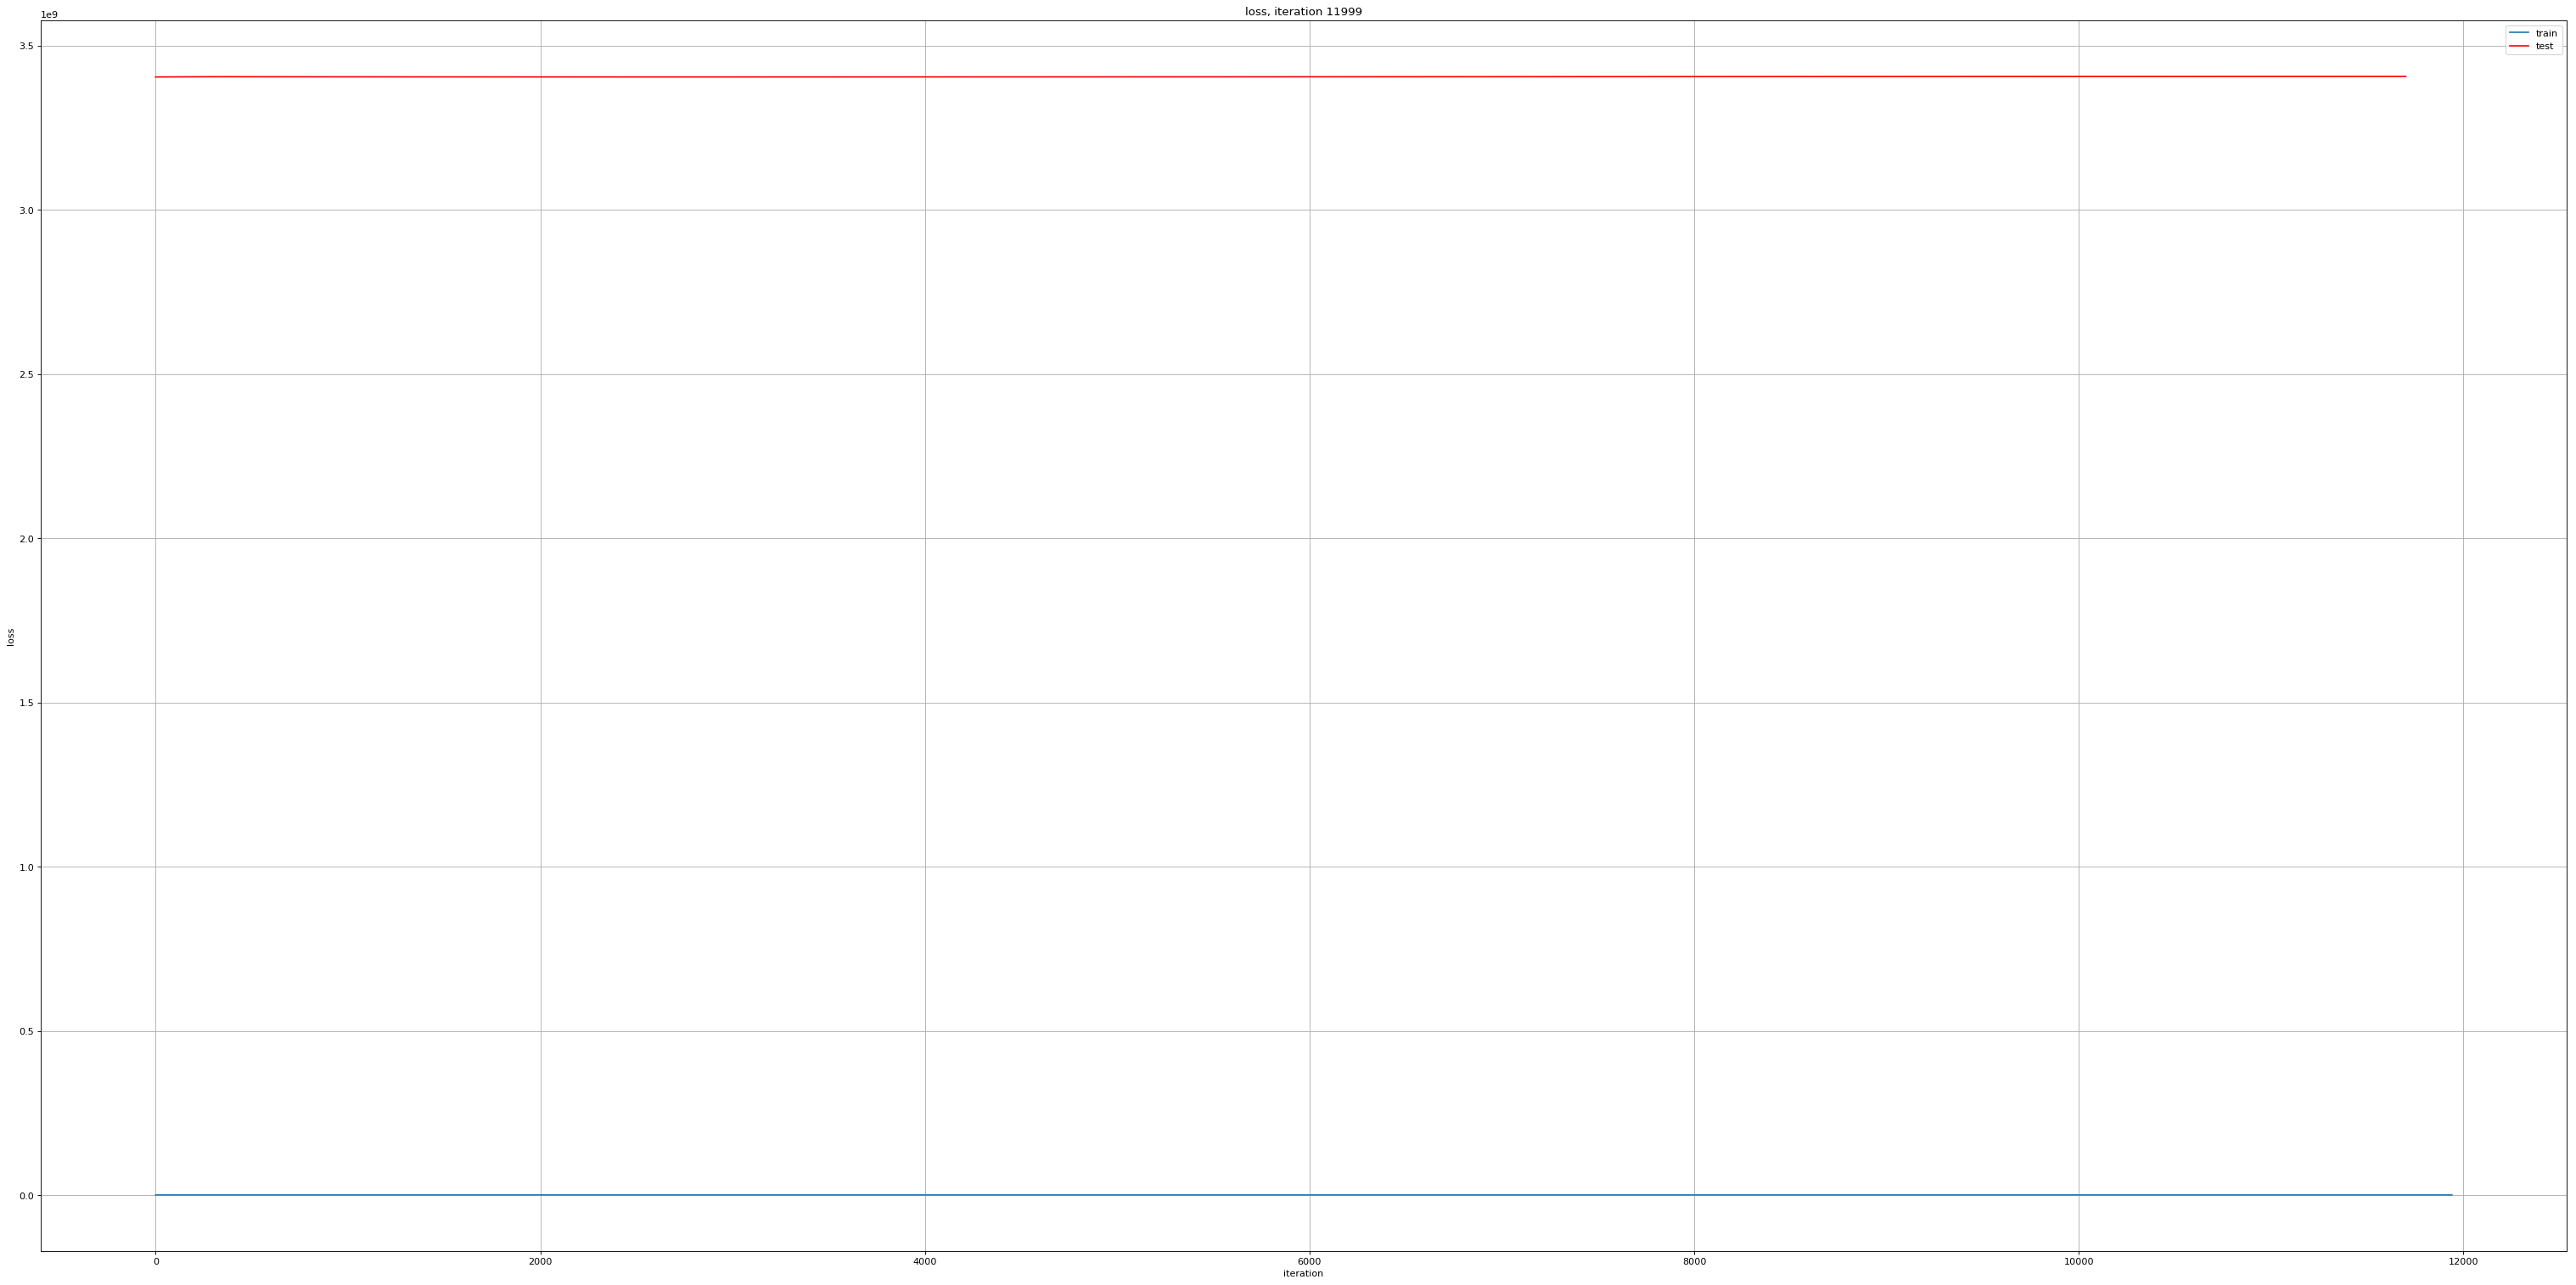

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(num=1, figsize=(48,24), dpi=80, facecolor='w', edgecolor='k')
plt.subplot()
plt.grid(True)
plt.plot(train_interval * np.arange(len(train_loss)), train_loss)
plt.plot(test_interval * np.arange(len(test_loss)), test_loss, 'r')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss, iteration %d' % it)
plt.legend(['train', 'test'], loc='best')
plt.show()


In [ ]:
plt.figure(num=1, figsize=(48,24), dpi=80, facecolor='w', edgecolor='k')
_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(train_interval * np.arange(len(train_loss)), train_loss)
ax2.plot(test_interval * np.arange(len(test_loss)), test_loss, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test loss')
plt.show()

### Test on Set5

In [4]:
import os
N = 297
SUB = 33
Nsubs = 30
ScaleFactor = 2
folder = 'datasets/Set5/original/'
originals = [os.path.join(folder,f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder,f))]
hrdir = os.path.join(folder,'hr/')
if not os.path.exists(hrdir):
    os.makedirs(hrdir)
    
lrdir = os.path.join(folder,'lr/')
if not os.path.exists(lrdir):
    os.makedirs(lrdir)

In [21]:
from PIL import Image
from PIL import ImageFilter
from random import randint

for idx, im in enumerate(originals):
    pim = Image.open(im)
    # pim = crop_center(pim, N, N)
    crops = generate_crops(Nsubs, N, N, SUB, SUB)
    for j, crop_tuple in enumerate(crops):
        sim = pim.crop(crop_tuple)
        sim.save(os.path.join(hrdir,'%d-%d.jpg' % (idx,j)))
        sim = sim.filter(ImageFilter.GaussianBlur(radius=1))
        sim = sim.resize((SUB // ScaleFactor, SUB // ScaleFactor), Image.BICUBIC)
        sim = sim.resize((SUB+delta,SUB+delta), Image.BICUBIC)
        sim.save(os.path.join(lrdir,'%d-%d-F%d.jpg' % (idx,j,ScaleFactor)))
        
    
    

In [5]:
lrs = sorted([os.path.join(lrdir,f) for f in os.listdir(lrdir) if os.path.isfile(os.path.join(lrdir,f))])
hrs = sorted([os.path.join(hrdir,f) for f in os.listdir(hrdir) if os.path.isfile(os.path.join(hrdir,f))])

In [6]:
print(lrs[:5])
print(hrs[:5])

['datasets/Set5/original/lr/0-0-F2.jpg', 'datasets/Set5/original/lr/0-1-F2.jpg', 'datasets/Set5/original/lr/0-10-F2.jpg', 'datasets/Set5/original/lr/0-11-F2.jpg', 'datasets/Set5/original/lr/0-12-F2.jpg']
['datasets/Set5/original/hr/0-0.jpg', 'datasets/Set5/original/hr/0-1.jpg', 'datasets/Set5/original/hr/0-10.jpg', 'datasets/Set5/original/hr/0-11.jpg', 'datasets/Set5/original/hr/0-12.jpg']


In [7]:
weights = 'snapshot/srcnn-dataset-x-24000.caffemodel'
model = 'srcnn-dataset-x-deploy.prototxt'

net = caffe.Net(model, weights, caffe.TEST)

In [9]:
from PIL import Image
results = []
psnrs = []

for idx,f in enumerate(lrs):
    x = np.array(Image.open(f))
    img = x[:,:,::-1]
    img = img.transpose((2,0,1))
    img = img[None,:]
    out = net.forward_all(data=img)
    res = out['result'][0]
    res = res.transpose((1,2,0))[:,:,::-1]
    results.append(res.astype('uint8'))
    y = np.array(Image.open(hrs[idx]))
    y = y[:,:,::-1]
    y = y.transpose((2,0,1))
    psnr = 20*np.log10(np.max(y)/np.sqrt((1.0/SUB**2)*(np.sum((y[0]-out['result'][0][0])**2)+np.sum((y[1]-out['result'][0][1])**2)+np.sum((y[2]-out['result'][0][2])**2))))
    psnrs.append(psnr)
    
    

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


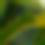

In [64]:
from PIL import Image
Image.open(lrs[0])

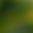

In [65]:
Image.fromarray(results[0])

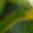

In [66]:
Image.open(hrs[0])

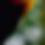

In [67]:
from PIL import Image
Image.open(lrs[1])

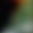

In [68]:
Image.fromarray(results[1])

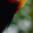

In [69]:
Image.open(hrs[1])

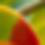

In [70]:
from PIL import Image
Image.open(lrs[2])

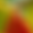

In [71]:
Image.fromarray(results[2])

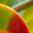

In [72]:
Image.open(hrs[2])

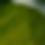

In [73]:
from PIL import Image
Image.open(lrs[3])

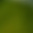

In [74]:
Image.fromarray(results[3])

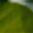

In [75]:
Image.open(hrs[3])

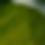

In [73]:
from PIL import Image
Image.open(lrs[4])

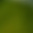

In [74]:
Image.fromarray(results[4])

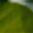

In [75]:
Image.open(hrs[4])

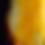

In [76]:
from PIL import Image
Image.open(lrs[5])

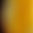

In [77]:
Image.fromarray(results[5])

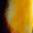

In [78]:
Image.open(hrs[5])

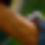

In [79]:
from PIL import Image
Image.open(lrs[15])

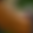

In [80]:
Image.fromarray(results[15])

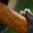

In [81]:
Image.open(hrs[15])

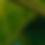

In [82]:
from PIL import Image
Image.open(lrs[25])

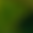

In [83]:
Image.fromarray(results[25])

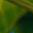

In [84]:
Image.open(hrs[25])

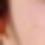

In [85]:
from PIL import Image
Image.open(lrs[35])

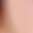

In [86]:
Image.fromarray(results[35])

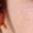

In [87]:
Image.open(hrs[35])

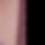

In [88]:
from PIL import Image
Image.open(lrs[45])

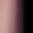

In [89]:
Image.fromarray(results[45])

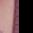

In [90]:
Image.open(hrs[45])

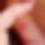

In [91]:
from PIL import Image
Image.open(lrs[55])

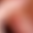

In [92]:
Image.fromarray(results[55])

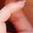

In [93]:
Image.open(hrs[55])

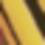

In [94]:
from PIL import Image
Image.open(lrs[65])

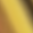

In [95]:
Image.fromarray(results[65])

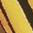

In [96]:
Image.open(hrs[65])

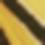

In [97]:
from PIL import Image
Image.open(lrs[75])

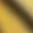

In [98]:
Image.fromarray(results[75])

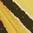

In [99]:
Image.open(hrs[75])

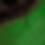

In [102]:
from PIL import Image
Image.open(lrs[95])

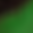

In [103]:
Image.fromarray(results[95])

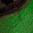

In [104]:
Image.open(hrs[95])

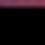

In [105]:
from PIL import Image
Image.open(lrs[105])

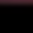

In [106]:
Image.fromarray(results[105])

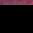

In [107]:
Image.open(hrs[105])

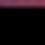

In [105]:
from PIL import Image
Image.open(lrs[115])

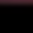

In [106]:
Image.fromarray(results[115])

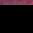

In [107]:
Image.open(hrs[115])

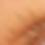

In [108]:
from PIL import Image
Image.open(lrs[125])

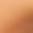

In [109]:
Image.fromarray(results[125])

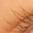

In [110]:
Image.open(hrs[125])

In [13]:
np.array(psnrs)

array([ 16.47596265,  12.22095345,  14.65992203,  14.78426752,
        26.92513986,  13.38272521,  17.81534125,  15.83787594,
        12.94398467,  11.3539593 ,  14.25040188,  11.70112424,
        15.54216317,  16.42360779,  16.78242721,  12.58257558,
        15.96138702,  16.16106757,  14.09972711,  15.16861028,
        20.5794808 ,  14.43591053,  16.68908914,  13.97554432,
        13.65731908,  17.26507562,  15.42373241,  15.76454946,
        17.3039379 ,  11.49212913,  16.87968643,  15.61847146,
               -inf,  27.45772349,  23.00067474,  14.61382099,
        13.60417744,  17.99075171,         -inf,  11.3565477 ,
               -inf,   9.1702314 ,  16.22372833,  12.45965813,
        17.6327807 ,  14.76332402,  13.87325966,  13.78425967,
        11.48283963,  16.11820801,         -inf,  14.20989368,
        15.01054294,  18.50489507,  12.60262547,  10.37790142,
               -inf,  17.4639738 ,  15.64175825,  18.12594815,
               -inf,  20.31815123,  10.61573738,   9.16

In [15]:
cleared_psnrs = [elem for elem in psnrs if elem > 0]        
cleared_psnrs

[16.475962652313193,
 12.220953448549574,
 14.659922029003523,
 14.784267520317387,
 26.925139862933719,
 13.38272521021743,
 17.815341250883286,
 15.837875944297139,
 12.943984671601282,
 11.353959300218657,
 14.25040187897798,
 11.701124241878071,
 15.542163171817309,
 16.423607794093865,
 16.78242720695993,
 12.582575581676831,
 15.961387017072372,
 16.161067572408232,
 14.099727113345166,
 15.168610278459685,
 20.579480801808792,
 14.435910528591716,
 16.689089142285582,
 13.975544321083637,
 13.657319081086934,
 17.265075621037312,
 15.423732413664212,
 15.764549460190358,
 17.303937898507883,
 11.492129130936586,
 16.879686431384698,
 15.618471458227653,
 27.457723492726824,
 23.000674737099608,
 14.613820989706195,
 13.604177439290726,
 17.990751711019783,
 11.35654769991713,
 9.1702313973374334,
 16.223728330559993,
 12.459658134828151,
 17.632780695367678,
 14.763324019274638,
 13.873259656407189,
 13.784259667996604,
 11.482839632151913,
 16.118208008450466,
 14.2098936763027

In [17]:
print(np.mean(cleared_psnrs))
print(np.sqrt(np.var(cleared_psnrs)))

15.9547661616
5.26950084403


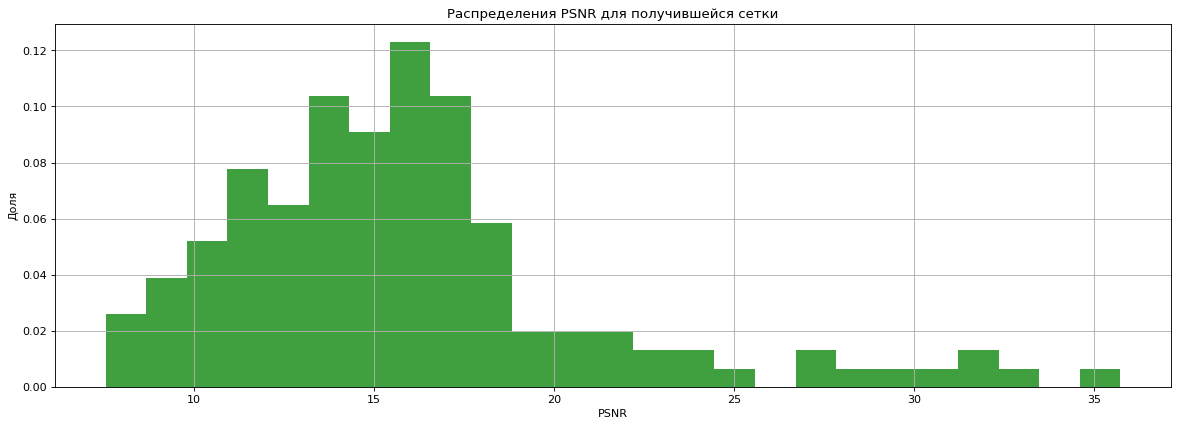

In [117]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot()

plt.grid(True)
plt.hist(cleared_psnrs, bins=25, color = 'g', normed=1, alpha=0.75)
plt.ylabel(u'Доля')
plt.xlabel(u'PSNR')
plt.title(u'Распределения PSNR для получившейся сетки')


plt.show()

In [54]:
from PIL import Image
from PIL import ImageFilter

bicubic_psnrs = []
for elem in hrs:
    sim = Image.open(elem)
    x = np.array(sim)
    x = x[:,:,::-1]
    x = x.transpose((2,0,1))
    sim = sim.filter(ImageFilter.GaussianBlur(radius=1))
    sim = sim.resize((SUB // ScaleFactor, SUB // ScaleFactor), Image.BICUBIC)
    sim = sim.resize((SUB,SUB), Image.BICUBIC)
    sim = np.array(sim)
    y = sim[:,:,::-1]
    y = y.transpose((2,0,1))
    psnr = 20*np.log10(np.max(y)/np.sqrt((1.0/SUB**2)*(np.sum((y[0]-x[0])**2)+np.sum((y[1]-x[1])**2)+np.sum((y[2]-x[2])**2))))
    bicubic_psnrs.append(psnr)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


In [55]:
x.shape

(3, 33, 33)

In [56]:
bicubic_psnrs

[30.257881476644364,
 25.973066029547045,
 25.630483391871174,
 29.29738285683214,
 27.806932048001045,
 30.469850086309137,
 25.066838018835359,
 27.954951860667975,
 26.935782419438688,
 27.432935191082613,
 24.814817445081978,
 24.507659014745805,
 27.563846758716192,
 30.652161531307382,
 27.319933963247735,
 24.175803604849072,
 27.947020386845356,
 26.172040283767807,
 26.11885083729852,
 24.230616867723388,
 26.965837649156565,
 28.855610621733927,
 29.358374324476753,
 25.507464857833163,
 29.784769360861318,
 26.368503881237793,
 29.46284848093341,
 25.667074808453268,
 26.858370429917201,
 24.636748739699378,
 27.834043170737139,
 25.520604394417269,
 nan,
 39.998268755520314,
 31.118948594266257,
 28.480548379423993,
 29.313863709597957,
 29.918466954478482,
 nan,
 26.991597532862865,
 nan,
 26.599052953873663,
 28.427632093395424,
 30.220268611877621,
 28.414281717814763,
 26.609614191441111,
 27.573466799512119,
 27.03969177293903,
 23.745826540560842,
 30.671645248399663,

In [57]:
bicubic_cleared_psnrs = [elem for elem in bicubic_psnrs if elem > 0]        
bicubic_cleared_psnrs

[30.257881476644364,
 25.973066029547045,
 25.630483391871174,
 29.29738285683214,
 27.806932048001045,
 30.469850086309137,
 25.066838018835359,
 27.954951860667975,
 26.935782419438688,
 27.432935191082613,
 24.814817445081978,
 24.507659014745805,
 27.563846758716192,
 30.652161531307382,
 27.319933963247735,
 24.175803604849072,
 27.947020386845356,
 26.172040283767807,
 26.11885083729852,
 24.230616867723388,
 26.965837649156565,
 28.855610621733927,
 29.358374324476753,
 25.507464857833163,
 29.784769360861318,
 26.368503881237793,
 29.46284848093341,
 25.667074808453268,
 26.858370429917201,
 24.636748739699378,
 27.834043170737139,
 25.520604394417269,
 39.998268755520314,
 31.118948594266257,
 28.480548379423993,
 29.313863709597957,
 29.918466954478482,
 26.991597532862865,
 26.599052953873663,
 28.427632093395424,
 30.220268611877621,
 28.414281717814763,
 26.609614191441111,
 27.573466799512119,
 27.03969177293903,
 23.745826540560842,
 30.671645248399663,
 27.7211752891790

In [59]:
print(np.mean(bicubic_cleared_psnrs))
print(np.sqrt(np.var(bicubic_cleared_psnrs)))

27.6246603612
4.45154171761


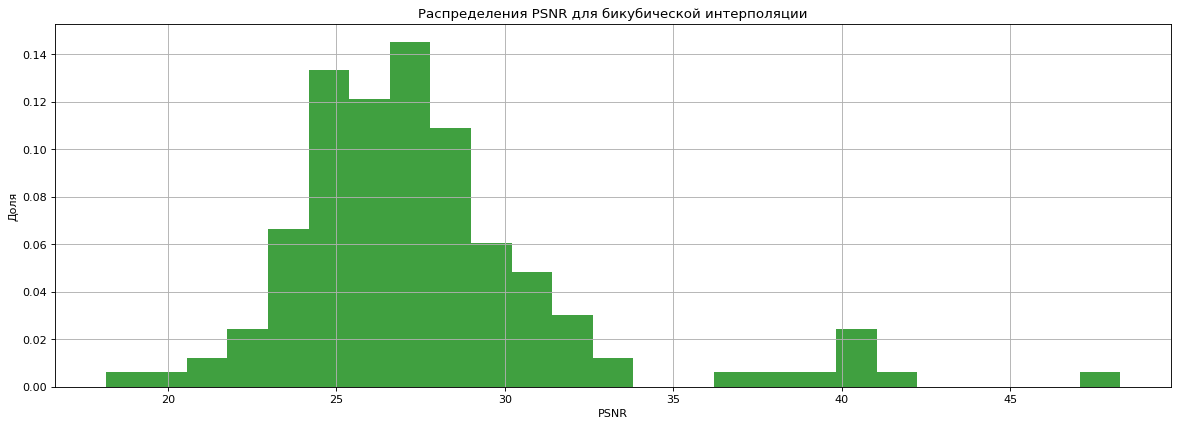

In [60]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot()

plt.grid(True)
plt.hist(bicubic_cleared_psnrs, bins=25, color = 'g', normed=1, alpha=0.75)
plt.ylabel(u'Доля')
plt.xlabel(u'PSNR')
plt.title(u'Распределения PSNR для бикубической интерполяции')


plt.show()

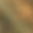

In [116]:
x = np.array(Image.open('datasets/berkley/BSDS300/images/test/original/lr/0-21-F2.jpg'))
img = x[:,:,::-1]
img = img.transpose((2,0,1))
img = img[None,:]
out = net.forward_all(data=img)
res = out['result'][0]
res = res.transpose((1,2,0))[:,:,::-1]
Image.fromarray(res.astype('uint8'))

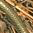

In [115]:
Image.open('datasets/berkley/BSDS300/images/test/original/hr/0-21.jpg')